In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import scanpy.external as sce
import bbknn
import mnnpy as mnn
import scgen
import matplotlib.pyplot as plt
import matplotlib as mpl

#settings
sc.settings.verbosity = 3             # show: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.figdir = "../../figures/ExternalDatasets/"
sc.settings.set_figure_params(dpi=80)

C:\Users\Juliska\Anaconda3\envs\UMCU\lib\site-packages\anndata\_core\anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.


scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [2]:
c_cont_red = mpl.colors.LinearSegmentedColormap.from_list('custom_red', 
                                             [(0, 'silver'),
                                              (0.1, (1, 0.82, 0.82)),
                                              (0.2, (1, 0.67, 0.67)),
                                              (0.3, (1, 0.58, 0.58)),
                                              (0.4, (1, 0.48, 0.48)),
                                              (0.5, (1, 0.38, 0.38)),
                                              (0.6, (1, 0.29, 0.29)),
                                              (0.7, (1, 0.22, 0.22)),
                                              (0.8, (1, 0.15, 0.15)),
                                              (0.9, (0.67, 0.09, 0.09)),
                                              (1, (0.54, 0, 0))], N=128)
c_cont_green = mpl.colors.LinearSegmentedColormap.from_list('custom_green', 
                                             [(0, 'silver'),
                                              (0.1, (0.50, 0.93, 0.60)),
                                              (0.2, (0.4, 0.89, 0.5)),
                                              (0.3, (0.3, 0.81, 0.4)),
                                              (0.4, (0.2, 0.73, 0.3)),
                                              (0.5, (0.1, 0.69, 0.2)),
                                              (0.6, (0, 0.62, 0.185)),
                                              (0.7, (0, 0.55, 0.16)),
                                              (0.8, (0, 0.47, 0.15)),
                                              (0.9, (0, 0.36, 0.11)),
                                              (1, (0, 0.29, 0.06))], N=128)
c_cont_blue = mpl.colors.LinearSegmentedColormap.from_list('custom_blue', 
                                             [(0, 'silver'),
                                              (0.1, (0.67, 0.77, 1)),
                                              (0.2, (0.58, 0.68, 1)),
                                              (0.3, (0.48, 0.58, 1)),
                                              (0.4, (0.38, 0.48, 1)),
                                              (0.5, (0.29, 0.39, 1)),
                                              (0.6, (0.22, 0.32, 1)),
                                              (0.7, (0.15, 0.25, 1)),
                                              (0.8, (0.09, 0.19, 1)),
                                              (0.9, (0, 0.1, 0.75)),
                                              (1, (0, 0.1, 0.5))], N=128)

Read data

In [63]:
adata = sc.read("../../../../data/input/diencephalon_guo_counts.txt").T

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [64]:
adata

AnnData object with n_obs × n_vars = 7365 × 22050 

Read in .csv file holding meta data, and set this in the object

In [65]:
meta_dienc = pd.read_csv("../../../../data/input/diencephalon_meta.csv", index_col=0)

In [66]:
meta_dienc

nGene   nUMI    orig.ident  percent.mito  res.0.5  res.1  \
AAACATACATCGGT    728   3839  Diencephalon      0.008075        8     10   
AAACGCTGAGCATC    750   4084  Diencephalon      0.024486        8     10   
AAAGGCCTGCCCTT    838   4537  Diencephalon      0.019396        8     10   
AAATCTGACCGATA    395   1923  Diencephalon      0.019241        8     10   
AACACTCTATGACC    880   5019  Diencephalon      0.025503        8     10   
...               ...    ...           ...           ...      ...    ...   
TACCATTGGCAAGG   1989  15649  Diencephalon      0.013956       15     19   
TCGAGCCTCAGTTG    957   5969  Diencephalon      0.010939       15     19   
TGGTAGTGGTTTCT   1210   8069  Diencephalon      0.019905       15     19   
TGTCTAACTGGATC    982   6178  Diencephalon      0.014274       15     19   
TTACAGCTCCAACA    353   1980  Diencephalon      0.003033       15     19   

                res.1.5  res.2  res.2.5  res.3  res.3.5  res.4  tree.ident  \
AAACATACATCGGT       14     14       15     17       16     14           5   
AAACGCTGAGCATC       14     14       15     17       16     14           5   
AAAGGCCTGCCCTT       14     14       15     17       16     14           5   
AAATCTGACCGATA       14     14       15     17       16     14           5   
AACACTCTATGACC       14     14       15     17       16     14           5   
...                 ...    ...      ...    ...      ...    ...         ...   
TACCATTGGCAAGG       25     27       29     30       33     35          18   
TCGAGCCTCAGTTG       25     27       29     30       33     35          18   
TGGTAGTGGTTTCT       25     27       29     30       33     35          18   
TGTCTAACTGGATC       25     27       29     30       33     35          18   
TTACAGCTCCAACA       25     27       29     30       33     35          18   

                nCount_alra  nFeature_alra  
AAACATACATCGGT          NaN            NaN  
AAACGCTGAGCATC          NaN            NaN  
AAAGGCCTGCCCTT          NaN            NaN  
AAATCTGACCGATA          NaN            NaN  
AACACTCTATGACC          NaN            NaN  
...                     ...            ...  
TACCATTGGCAAGG          NaN            NaN  
TCGAGCCTCAGTTG          NaN            NaN  
TGGTAGTGGTTTCT          NaN            NaN  
TGTCTAACTGGATC          NaN            NaN  
TTACAGCTCCAACA          NaN            NaN  

[7365 rows x 15 columns]

In [67]:
adata.obs = meta_dienc

In [68]:
adata.obs["tree.ident"] = adata.obs["tree.ident"].astype(str)

Filter out genes expressed in less that 4 cells

In [69]:
adata

AnnData object with n_obs × n_vars = 7365 × 22050 
    obs: 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'res.0.5', 'res.1', 'res.1.5', 'res.2', 'res.2.5', 'res.3', 'res.3.5', 'res.4', 'tree.ident', 'nCount_alra', 'nFeature_alra'

In [70]:
sc.pp.filter_genes(adata, min_cells=4)

filtered out 7585 genes that are detected in less than 4 cells


In [71]:
adata

AnnData object with n_obs × n_vars = 7365 × 14465 
    obs: 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'res.0.5', 'res.1', 'res.1.5', 'res.2', 'res.2.5', 'res.3', 'res.3.5', 'res.4', 'tree.ident', 'nCount_alra', 'nFeature_alra'
    var: 'n_cells'

Normalize + log-transform data

In [72]:
sc.pp.normalize_total(adata, key_added='n_counts_norm',layers = 'all')

normalizing counts per cell
    finished (0:00:00)


In [73]:
sc.pp.log1p(adata)

Highly variable genes

In [74]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [75]:
#adata = adata[:, adata.var['highly_variable']]
#adata

In [76]:
sc.tl.pca(adata, svd_solver='arpack')

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:01)


In [77]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) 

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)


In [78]:
sc.tl.tsne(adata) 

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:54)


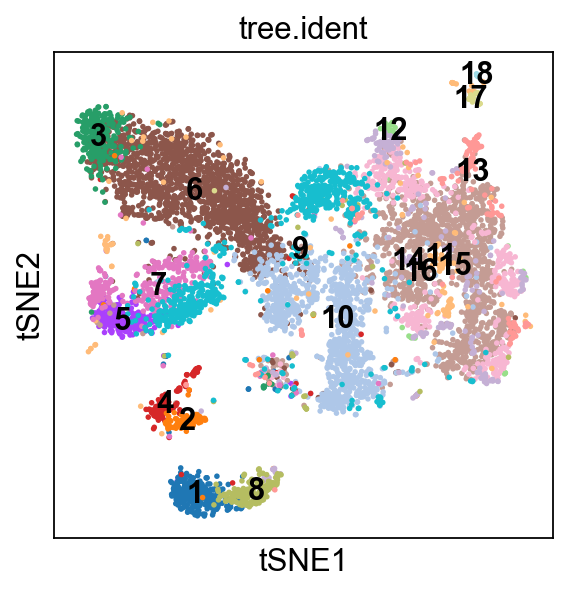

In [82]:
sc.pl.tsne(adata, color=['tree.ident'], s=25, legend_loc="on data")

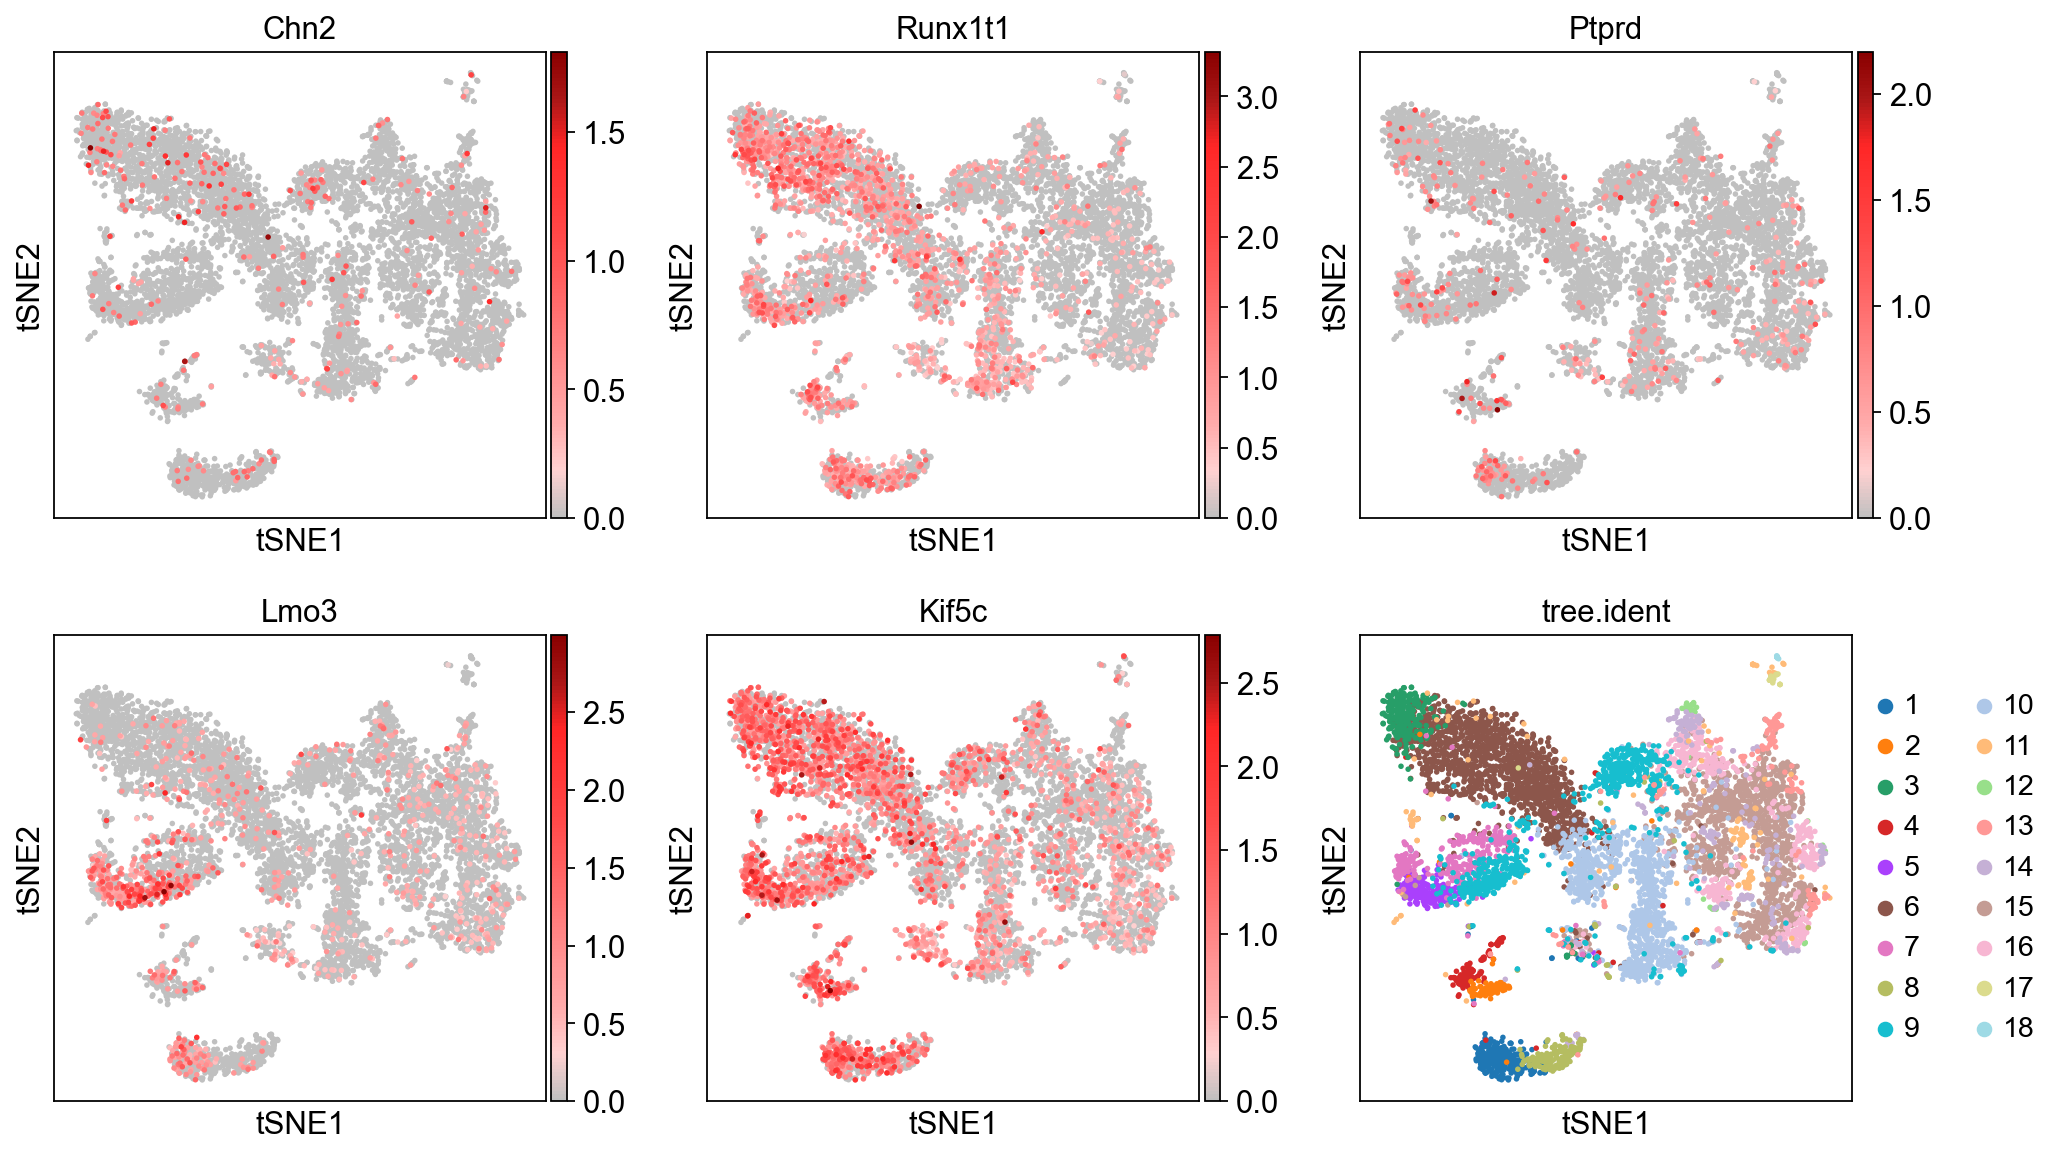

In [100]:
sc.pl.tsne(adata, color=["Chn2", "Runx1t1", "Ptprd", "Lmo3", "Kif5c", "tree.ident"], s=25, cmap=c_cont_red, ncols=3,
          save="_iHb2-figc.pdf")

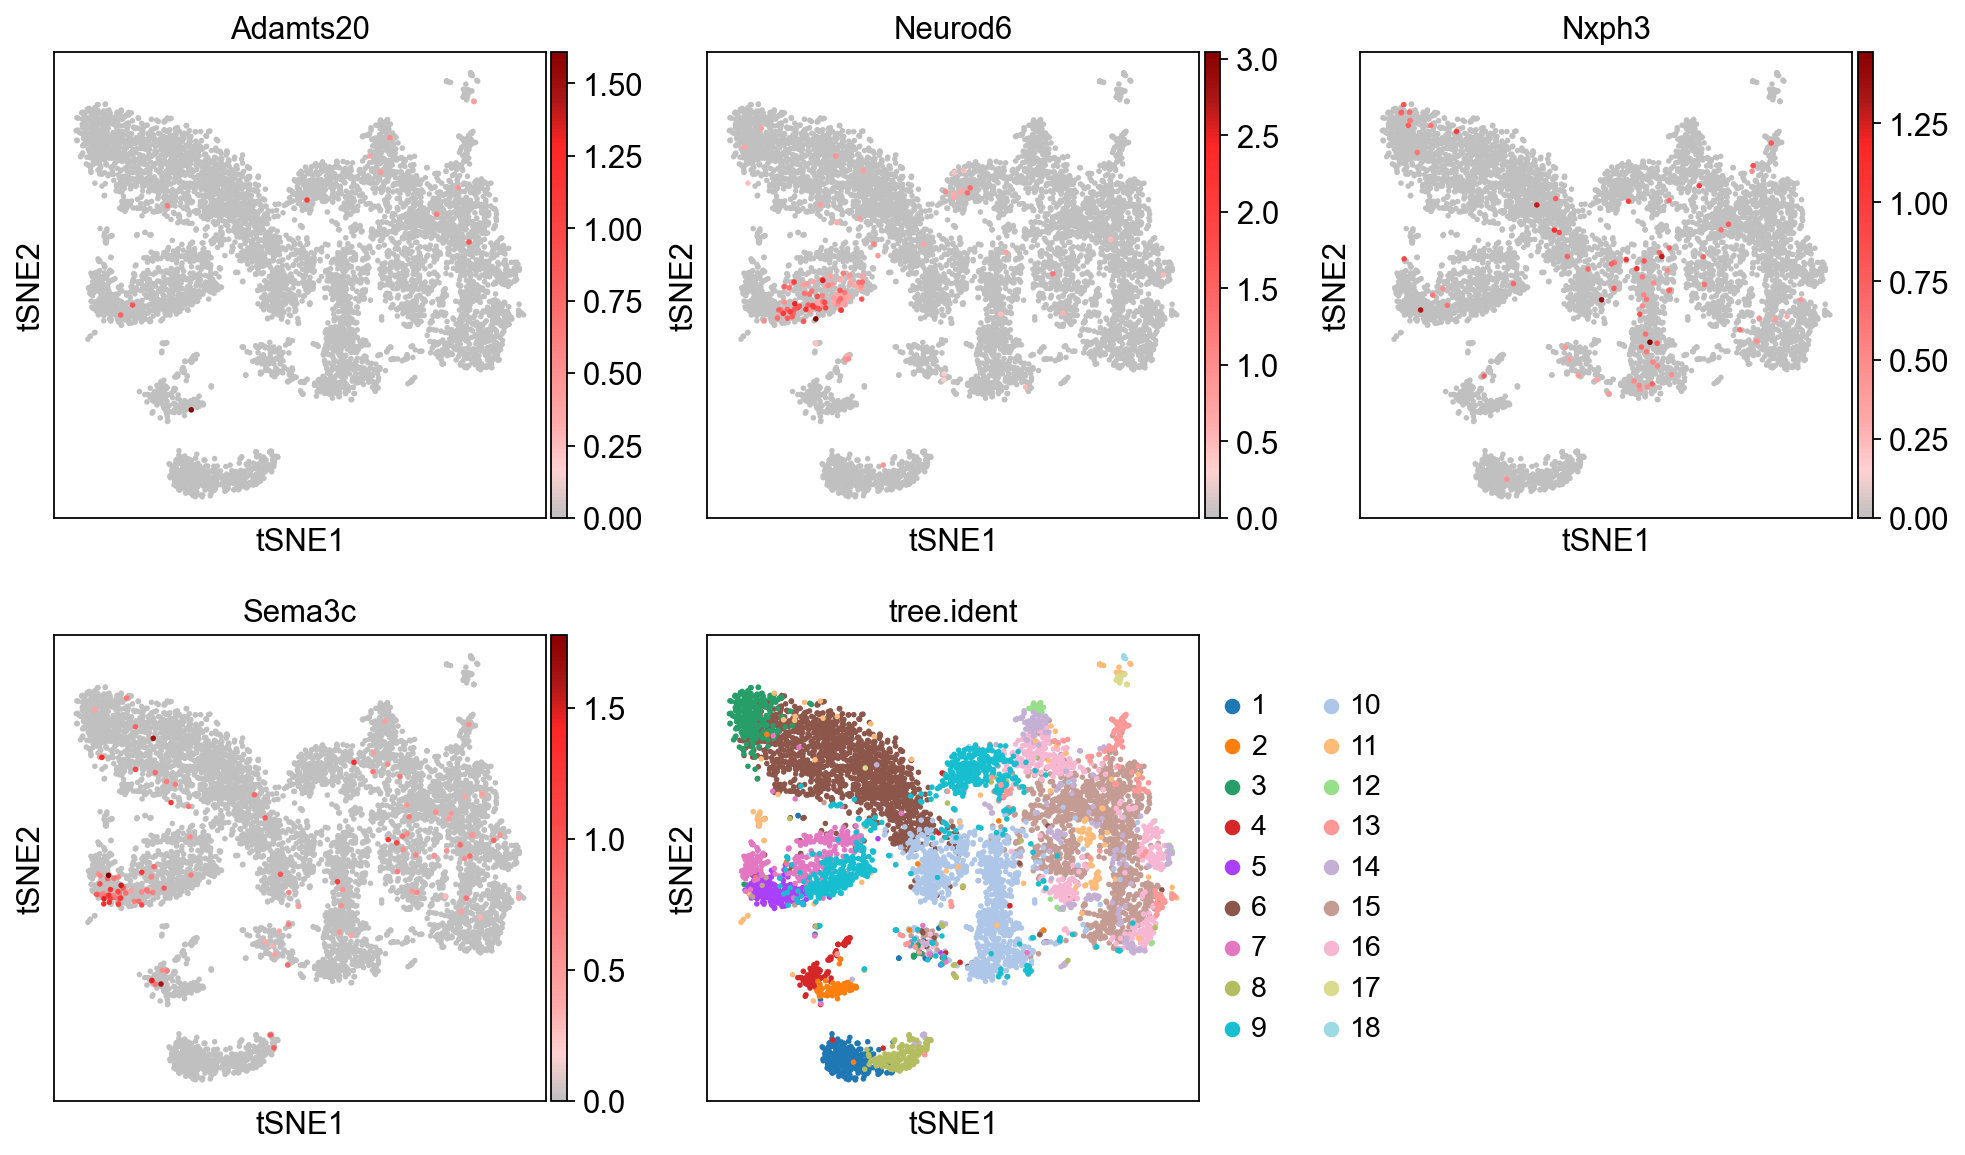

In [101]:
sc.pl.tsne(adata, color=["Adamts20", "Neurod6", "Nxph3", "Sema3c", "tree.ident"], s=25, cmap=c_cont_red, ncols=3,
          save="_iHb2-figd.pdf")

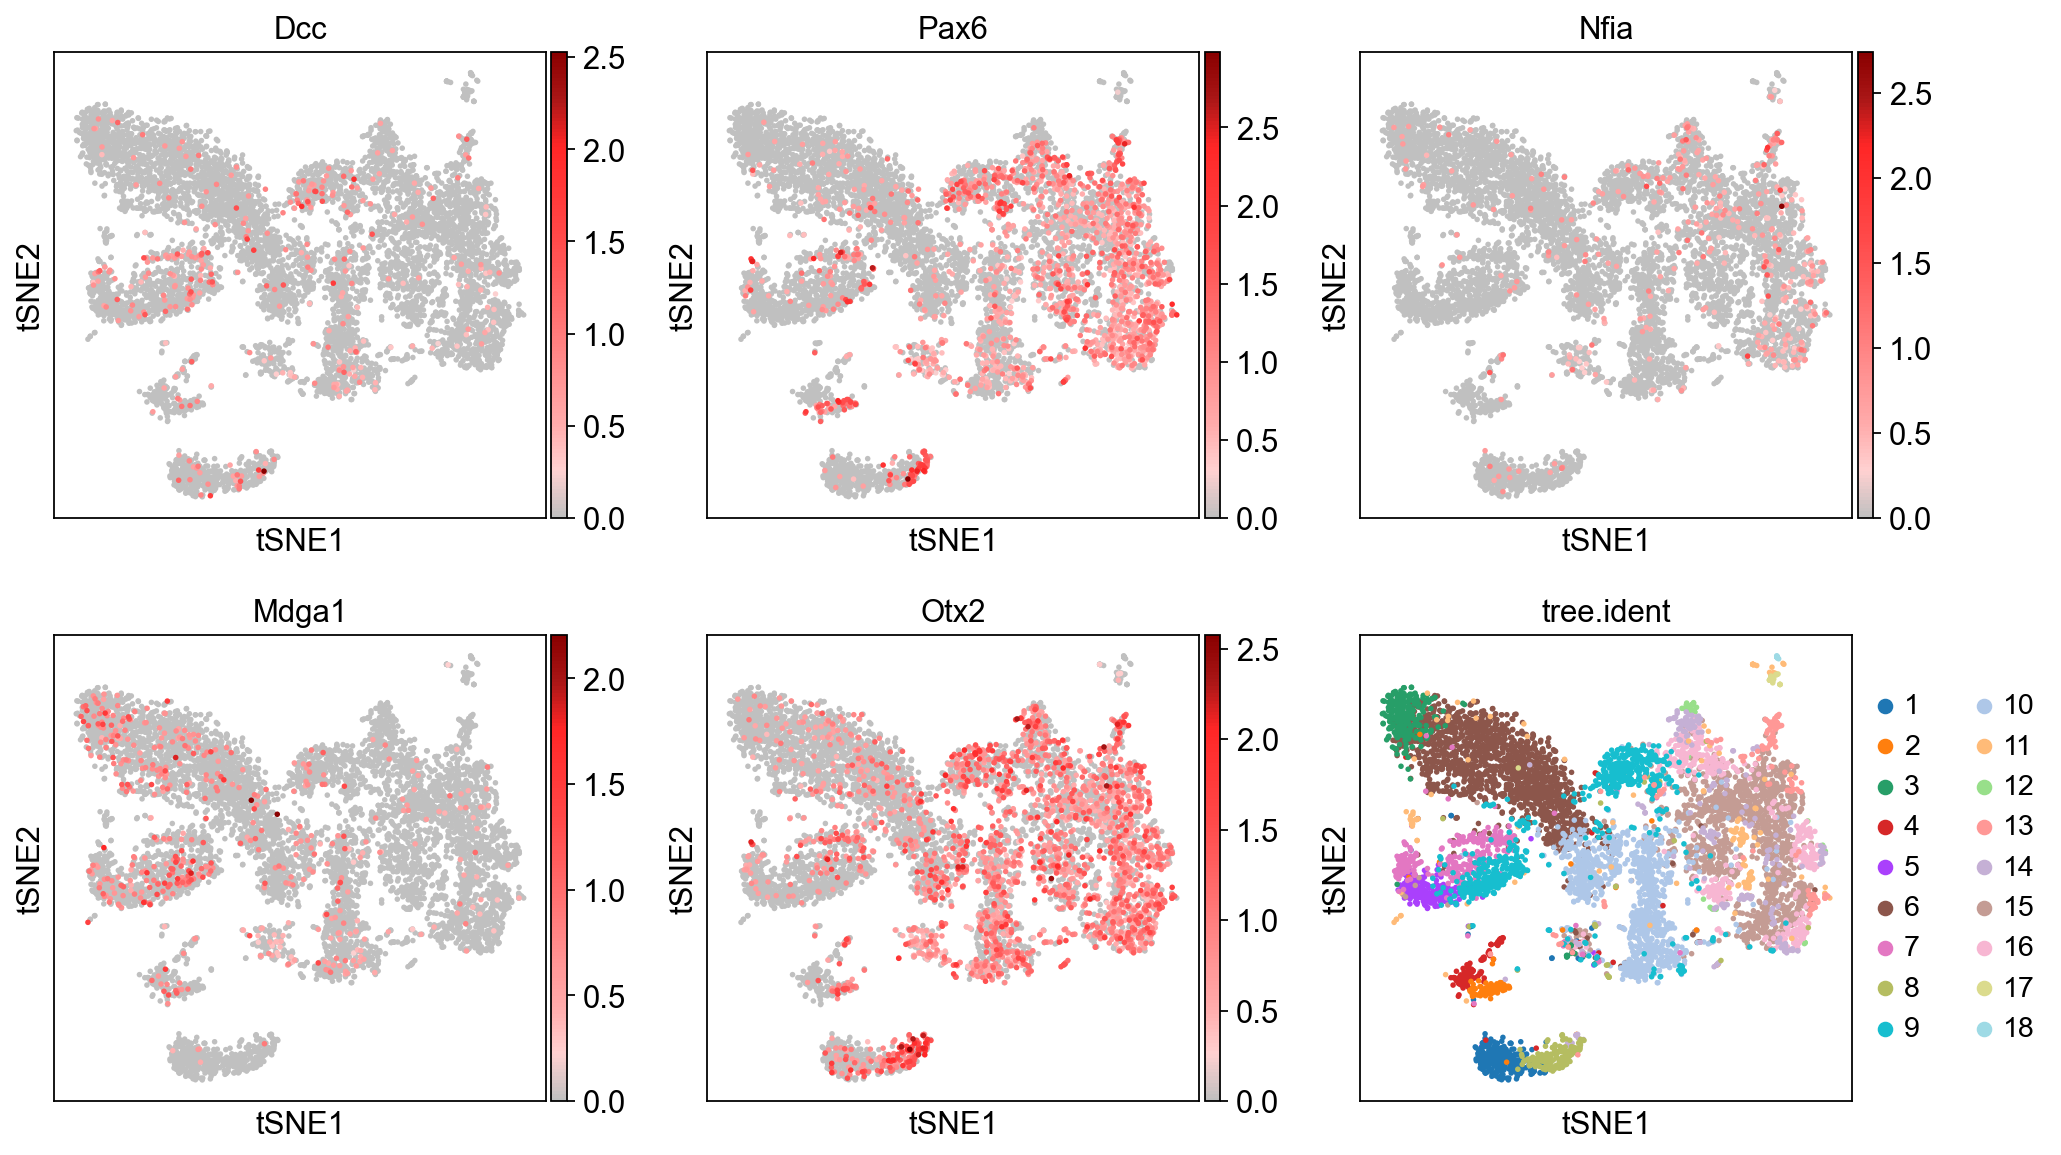

In [102]:
sc.pl.tsne(adata, color=["Dcc", "Pax6", "Nfia", "Mdga1", "Otx2", "tree.ident"], s=25, cmap=c_cont_red, ncols=3,
          save="_iHb1-figc.pdf")

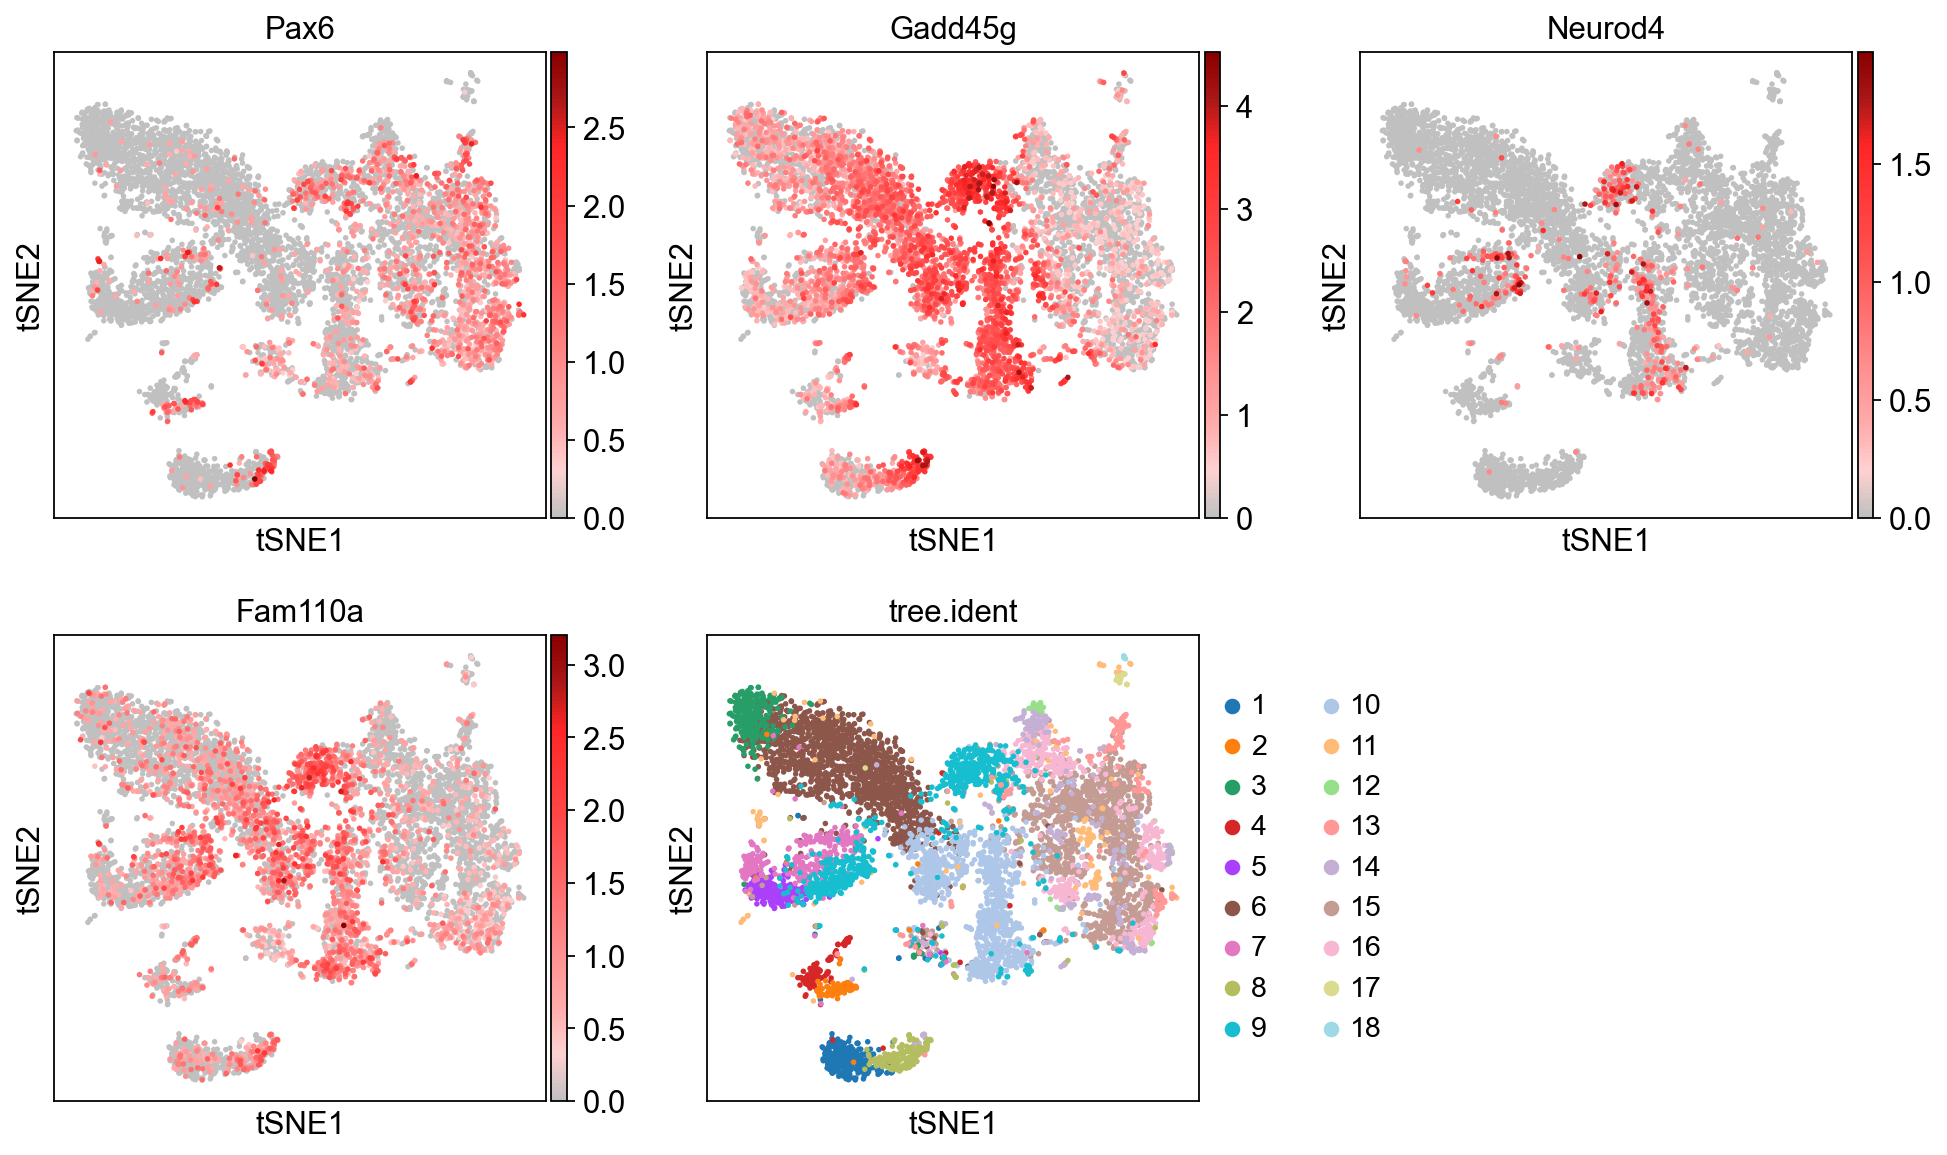

In [103]:
sc.pl.tsne(adata, color=["Pax6", "Gadd45g", "Neurod4", "Fam110a", "tree.ident"], s=25, cmap=c_cont_red, ncols=3,
          save="_iHb1-figd.pdf")

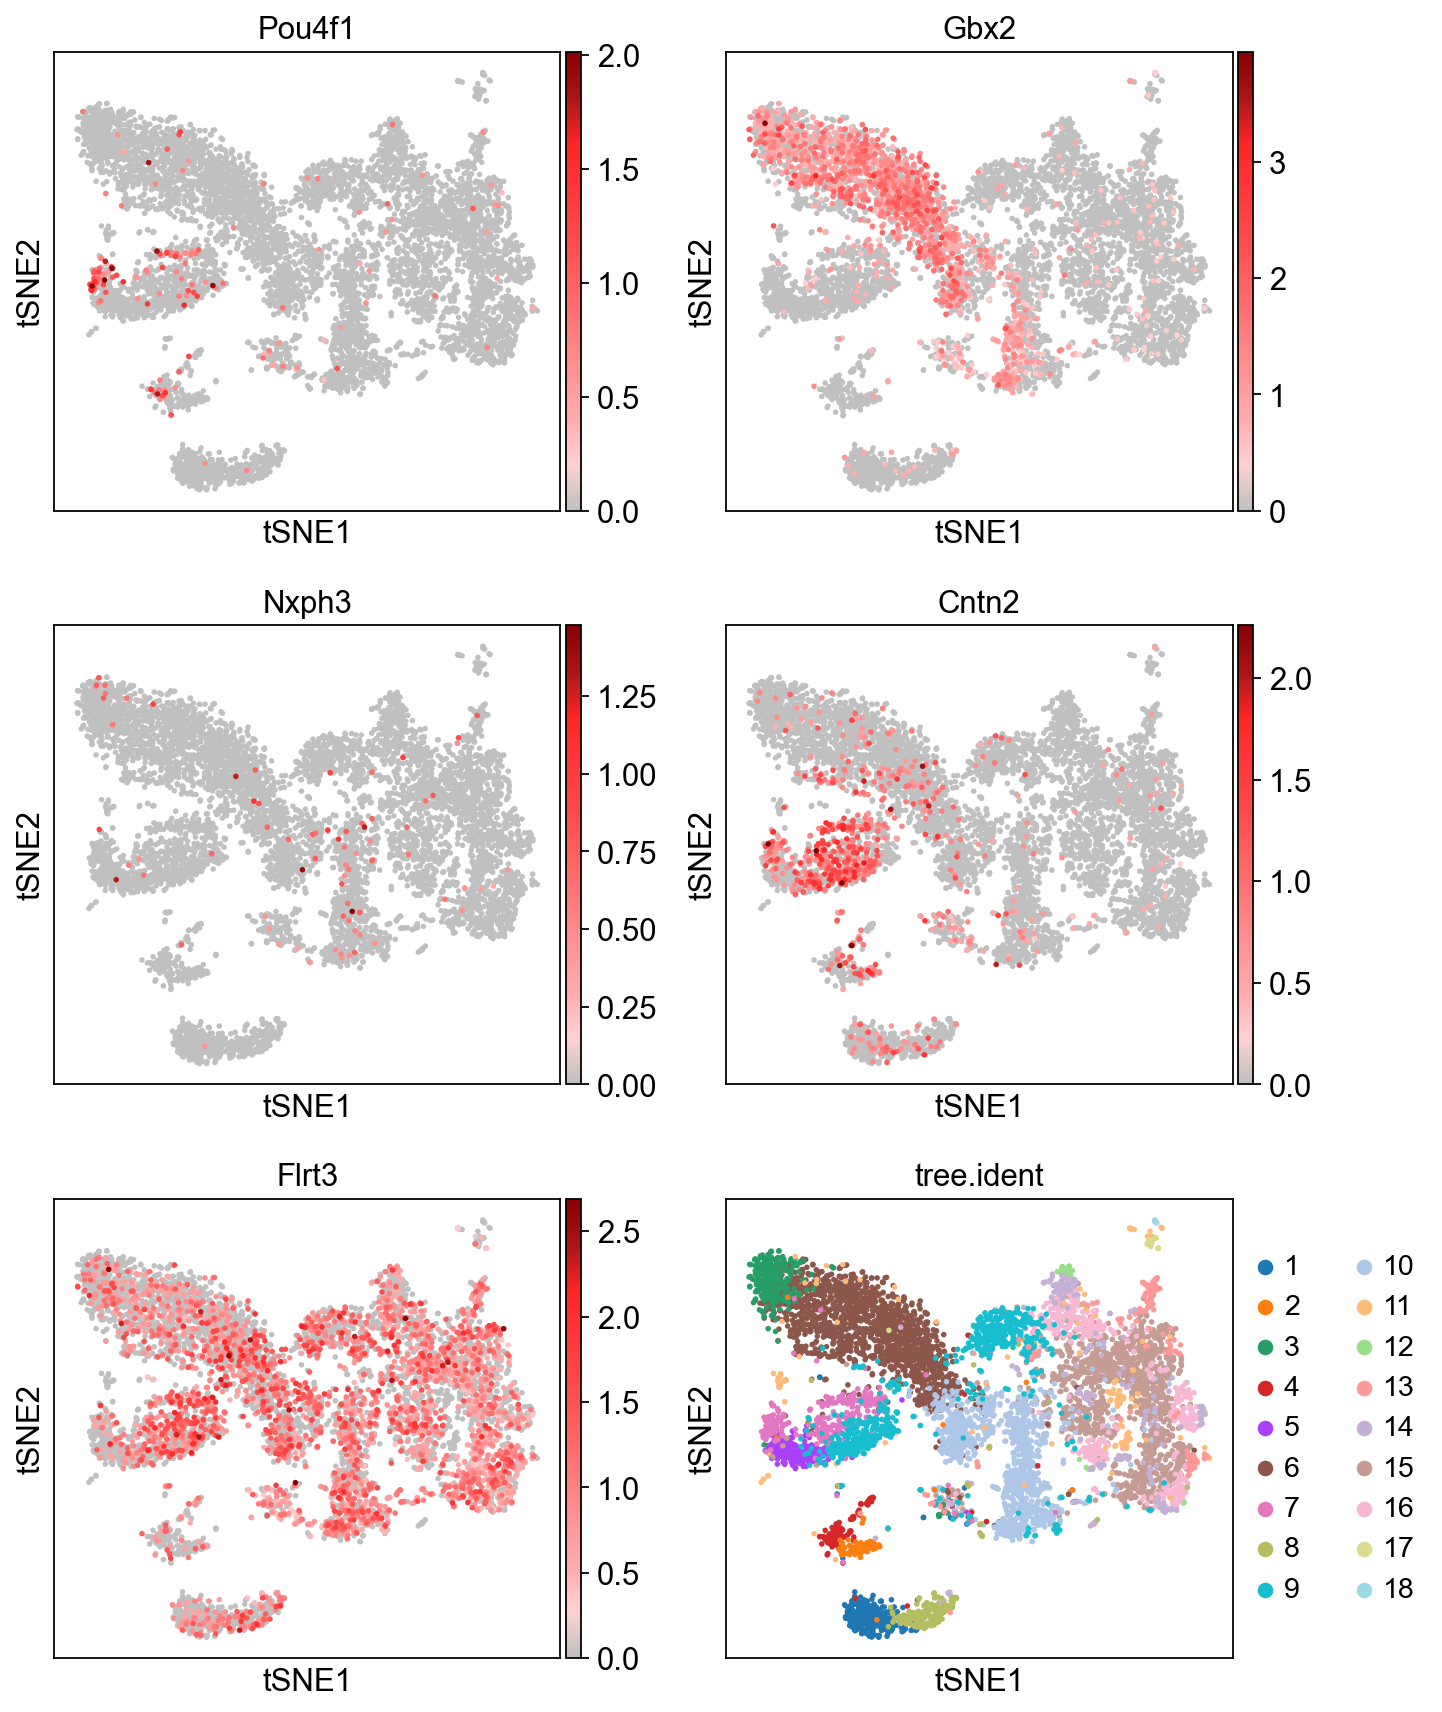

In [105]:
sc.pl.tsne(adata, color=["Pou4f1", "Gbx2", "Nxph3", "Cntn2", "Flrt3", "tree.ident"], s=25, cmap=c_cont_red, ncols=2,
          save="_markers.pdf")